<h1><a id='outline'>Project Outline</a></h1>

* [Libraries](#libs)
* [Initial Data exploration](#ide)
* [Homework 2 Questions PDF](#hw2qs)
* [References](#refs)
    * [Stormo Paper](#stormo)
    * [Monte Carlo notes](#mcmc)

# Libraries

In [1]:
%matplotlib inline
from Bio import motifs as Motifs # If this doesn't load: conda install -c bioconda biopython
from Bio.SeqIO import index as fIndex
from IPython.display import display, Image, Audio
from itertools import product as cartProduct
from math import log
from numpy import dot as dotp
from pandas import DataFrame, read_csv, Series
from scipy.stats import chi2, multinomial
from timeit import default_timer as timer
from wand.image import Image as WImage #Comment this out if you don't need to display a NEW PDF pip install Wand

class valWrapper:
    def __init__(self,value): self.value=value
    def __getitem__(self, index): return float(self.value[index])
class dfWrapper():
    def __init__(self,df): 
        self.df=df
        self.itemGetter = {type(''):self._getBase,type(1):self._getPos}
    def _getPos(self,key): return self.df[key]
    def _getBase(self,key): return valWrapper(self.df[self.df.index==key])
    def __getitem__(self, key): return self.itemGetter[type(key)](key)

<h2><a id="ide">Initial Data exploration</a></h2>

There are 3264 transcription factor binding site sequeneces
Of those, there are 1275 unique senequences


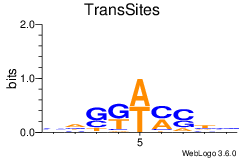

In [2]:
tfSites = fIndex("transciptionFactorBindingMotifs.fasta","fasta")
print("There are %i transcription factor binding site sequeneces" % (len(tfSites)))
seqs = []
for seq in tfSites.values():seqs.append(str(seq.seq).upper())
knownTs = set(seqs)
print("Of those, there are %i unique senequences" % (len(knownTs)))
motif = Motifs.create(seqs)
# print motif.counts.normalize()
motif.weblogo("tfSitesLogo.png",format='png',**{'logo_title':"TransSites",'show_ends':False,'unit_name':"",'stack_width':'large','show_errorbars':False})    
display(Image("tfSitesLogo.png"))

<h2 style="color:darkgreen"><a id="ia">Question 1a</a></h2>

In [3]:
motif.counts

{'G': [846, 700, 1768, 1736, 0, 215, 1010, 554, 1255],
 'A': [600, 1465, 82, 152, 1692, 1255, 483, 590, 608],
 'T': [608, 587, 476, 1177, 1572, 170, 92, 1475, 598],
 'C': [1210, 512, 938, 199, 0, 1624, 1679, 645, 803]}

In [4]:
pfm = DataFrame(motif.counts,index=range(1,10),columns=['A','C','G','T']).transpose()
pfm=pfm.reindex(['A','C','G','T'])
pwm = pfm/pfm.sum()
pwm # or motif.pwm but dataframe displays prettier

,1,2,3,4,5,6,7,8,9
A,0.183824,0.448836,0.025123,0.046569,0.518382,0.384498,0.147978,0.18076,0.186275
C,0.370711,0.156863,0.287377,0.060968,0.000000,0.497549,0.514400,0.19761,0.246017
G,0.259191,0.214461,0.541667,0.531863,0.000000,0.065870,0.309436,0.16973,0.384498
T,0.186275,0.179841,0.145833,0.360600,0.481618,0.052083,0.028186,0.45190,0.183211


In [5]:
pwm = dfWrapper(pwm)

<h4><a id="trans">Build Position weighted data structure for single base transitions</a></h4>

In [6]:
Ps = {}
#Initialize the Ps matrix
for pos in range(1,9):
    Ps[pos]={}
    for firstBase,secondBase in cartProduct(['A','C','G','T'],['A','C','G','T']):
        try: Ps[pos][firstBase][secondBase] = 0
        except: Ps[pos][firstBase] = {secondBase:0}

#Count the number of times each base is found together in the motifs
for seq in seqs:
    for pos in range(0,8): Ps[pos+1][seq[pos]][seq[pos+1]]+=1

#Scale to make a PW transition matrix
transMat = {}
for pos in range(1,9):
    transMat[pos] = {}
    for firstBase,secondBase in cartProduct(['A','C','G','T'],['A','C','G','T']):
        rc_total = Series(Ps[pos][firstBase]).sum()
        if rc_total == 0.0:
            try: transMat[pos][firstBase][secondBase] = 0.0
            except: transMat[pos][firstBase] = {secondBase: 0.0}
        else:
            try: transMat[pos][firstBase][secondBase] = Ps[pos][firstBase][secondBase]/rc_total
            except: transMat[pos][firstBase] = {secondBase: Ps[pos][firstBase][secondBase]/rc_total}

<h2 style="color:darkgreen"><a id="1bi">Question 1b.i</a></h2>

<h4><a id="lho"></a>L(Ho)</h4>

In [7]:
LL_Ho = 0.0
for seq in seqs:
    for pos in range(1,10): LL_Ho += log(pwm[pos][seq[pos-1]])
print("Log likelihood of the null given the data:",LL_Ho)

Log likelihood of the null given the data: -33183.59287371202


<h4><a id="lha"></a>L(Ha)</h4>

In [8]:
LL_Ha = 0.0
for seq in seqs:
    LL_Ha += log(pwm[1][seq[0]])
    for pos in range(0,8): LL_Ha += log(transMat[pos+1][seq[pos]][seq[pos+1]])
print("Log likelihood of the alternative given the data:",LL_Ha)

Log likelihood of the alternative given the data: -24490.891541478286


In [9]:
lmbda = 2*(LL_Ha-LL_Ho)
print("Lambda:",lmbda, "DF:",(3+12*8)-(9*3))
print("Pvalue for the LRT: ",chi2.pdf(lmbda,(3+12*8)-(9*3)))

Lambda: 17385.402664467467 DF: 72
Pvalue for the LRT:  0.0


<h4><a id="lho"></a>Create objects to lend to generating sequence data</h4>

In [10]:
seqMapper = {'1000':'A','0100':'C','0010':'G', '0001':'T'} # Single base generations

index = 0
for b1,b2 in cartProduct(['A','C','G','T'],['A','C','G','T']): # 2 base generations
    indetifier = '0' * index + '1' + '0' * (15-index)
    index += 1
    seqMapper[indetifier] = b1+b2
index = 0
for b1,b2,b3 in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T']): # 3 base generations
    indetifier = '0' * index + '1' + '0' * (63-index)
    index += 1
    seqMapper[indetifier] = b1+b2+b3
    
index = 0
for b1,b2,b3,b4 in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']): # 4 base generations
    indetifier = '0' * index + '1' + '0' * (255-index)
    index += 1
    seqMapper[indetifier] = b1+b2+b3+b4
    
index = 0
for b1,b2,b3,b4,b5 in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']): # 5 base generations
    indetifier = '0' * index + '1' + '0' * (1023-index)
    index += 1
    seqMapper[indetifier] = b1+b2+b3+b4+b5

rv = multinomial.rvs
class randBase:
    def __init__(self,pVals):
        base = rv(1,pVals)
        self.seq = seqMapper[''.join(str(v) for v in base)]
    def __hash__(self):return hash(self.seq)
    def __str__(self):return self.seq   
    def __add__(self, other): return str(self) + other
    def __radd__(self, other): return other + str(self)

In [ ]:
%%bash
git add HW2Notebook.ipynb;
git commit -m " ";
git push

In [11]:
"""
pwm - Probability weighted matrix 
numSims - Number of simulations
"""
def simulateIndepSeqModel(pwm,numSeqs,numSims=10000,seqLen=9,knownSeqs=set()):
    succesfulSims, total, totalKnown = 0, 0, 0
    for sim in range(numSims):
        numTimesGenSequenceInKnown = 0
        for seq in range(numSeqs):
            seq = ""
            for pos in range(1,seqLen+1): seq += randBase(pwm[pos])
            numTimesGenSequenceInKnown += int((seq in knownTs))
            total += 1
        totalKnown += numTimesGenSequenceInKnown
        succesfulSims += int((numTimesGenSequenceInKnown >= numSeqs))
    if succesfulSims == 0: succesfulSims += 1; numSims += 1
    return (totalKnown/float(total))*100, succesfulSims/float(numSims) # %simulations fitting data, Pval
    
def simulateMarkovChainModel(pwm,transMatrix,numSeqs,numSims=1000,seqLen=9,knownSeqs=set()):
    succesfulSims, total, totalKnown = 0, 0, 0
    for sim in range(numSims):
        numTimesGenSequenceInKnown = 0
        for seq in range(numSeqs):
            seq = str(randBase(pwm[1]))
            for pos in range(1,seqLen): seq += randBase(list(transMatrix[pos][seq[-1]].values()))
            numTimesGenSequenceInKnown += int((seq in knownTs))
            total += 1
        totalKnown += numTimesGenSequenceInKnown
        succesfulSims += int((numTimesGenSequenceInKnown >= numSeqs))
    return totalKnown/float(total)*100, succesfulSims/float(numSims)

'''
Order must be >= 2
'''
def simulateMarkovChainModelOrderN(pwm,transMatrix,numSeqs,numSims=1000,order=2,seqLen=9,knownSeqs=set()):
    succesfulSims, total, totalKnown = 0, 0, 0
    numTimesGenSequenceInKnown = 0
    for sim in range(numSims):
        numTimesGenSequenceInKnown = 0
        for seq in range(numSeqs):
            seq = str(randBase(pwm))
            for pos in range(1,(seqLen-order)+1): seq += randBase(list(transMatrix[pos][seq[-order:]].values()))
            numTimesGenSequenceInKnown += int((seq in knownTs))
            total += 1
        totalKnown += numTimesGenSequenceInKnown
        succesfulSims += int((numTimesGenSequenceInKnown >= numSeqs))
    if succesfulSims == 0: succesfulSims += 1; numSims += 1
    return totalKnown/float(total)*100, succesfulSims/float(numSims)


<h2 style="color:darkgreen"><a id="1bii">Question 1b.ii</a></h2>

In [12]:
ismPerCorrect, pvalISM = simulateIndepSeqModel(pwm,len(seqs),1000)
mcmPerCorrect, pvalMCM = simulateMarkovChainModel(pwm,transMat,len(seqs),1000)
print("Percent success generating a known transcription factor sequence using an independent sites model: %.3f%%" % (ismPerCorrect))
print("ISM Model P-Value <= %.3f" % pvalISM)
print("Percent success generating a known transcription factor sequence using markov chain model %.3f%%" % (mcmPerCorrect))
print("MC Model P-Value <= %.3f" % pvalMCM)

Percent success generating a known transcription factor sequence using an independent sites model: 7.033%
ISM Model P-Value <= 0.009900990099009901
Percent success generating a known transcription factor sequence using markov chain model 72.617%
MC Model P-Value <= 0.0


<h2 style="color:darkgreen"><a id="ic">Question 1c</a></h2>

In [ ]:
#Be sure to run the pw2/transMat2,3,4 etc below BEFORE you run these
print ("Order 2: %.3f%% %.3f" % (simulateMarkovChainModelOrderN(list(pwm2.values()),transMat2,len(seqs),1000,order=2)))
print ("Order 3: %.3f%% %.3f" % (simulateMarkovChainModelOrderN(list(pwm3.values()),transMat3,len(seqs),1000,order=3)))
print ("Order 4: %.3f%% %.3f" % (simulateMarkovChainModelOrderN(list(pwm4.values()),transMat4,len(seqs),1000,order=4)))
print ("Order 5: %.3f%% %.3f" % (simulateMarkovChainModelOrderN(list(pwm5.values()),transMat5,len(seqs),1000,order=5)))

<h3 style="color:darkgreen"><a id="ic">Order 2</a></h3>

In [14]:
# Do an order 2 mc instead of order 1
P2s = {}
#Initialize the Ps matrix
for pos in range(1,9):
    P2s[pos]={}
    for firstBase,secondBase,thirdBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        try: P2s[pos][firstBase+secondBase][thirdBase] = 0.0
        except: P2s[pos][firstBase+secondBase] = {thirdBase:0.0}

#Count the number of times each base is found together
for seq in seqs:
    for pos in range(0,7): P2s[pos+1][seq[pos:pos+2]][seq[pos+2]]+=1

#Compute the transition matrix        
transMat2 = {}
for pos in range(1,9):
    transMat2[pos] = {}
    for firstBase,secondBase,thirdBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        rc_total = Series(P2s[pos][firstBase+secondBase]).sum()
        try: transMat2[pos][firstBase+secondBase][thirdBase] = P2s[pos][firstBase+secondBase][thirdBase]/rc_total
        except: transMat2[pos][firstBase+secondBase] = {thirdBase: P2s[pos][firstBase+secondBase][thirdBase]/rc_total}

#Compute the null (order 1 model)
LL_Ho = 0.0
for seq in seqs:
    LL_Ho += log(pwm[1][seq[0]])
    for pos in range(0,8):
        LL_Ho += log(transMat[pos+1][seq[pos]][seq[pos+1]])
print("LL_Ho",LL_Ho)      

#Compute the alphas for order 2
pwm2 = {}
for pair in transMat2[1]:
    countSum = Series(P2s[1][pair]).sum()
    pwm2[pair] = countSum/len(seqs)
    
#Compute the alternate (order 2 model)
LL_Ha = 0.0
for seq in seqs:
    LL_Ha += log(pwm2[seq[0:2]])
    for pos in range(0,7):
        LL_Ha += log(transMat2[pos+1][seq[pos:pos+2]][seq[pos+2]])
print("LL_Ha",LL_Ha) 
lmbda = 2*(LL_Ha-LL_Ho)
print(lmbda)
chi2.pdf(lmbda,(64*7+16 - ((16*7)+1)) -  (3+12*8))

LL_Ho -24490.891541478286
LL_Ha -23836.890444189088
1308.0021945783956


/mnt/home/dooleys1/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/mnt/home/dooleys1/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


2.200067769067237e-142

<h2 style="color:darkgreen"><a id="ic">Question 2a</a></h2>

In [ ]:
# the promotors file was dirty so I made it all upper case and replaced the file
# from Bio.SeqIO import parse
# fh = open("Promoters.fa",'w')
# for rec in parse("promoters.fasta","fasta"):
#     fh.write(">%s\n%s\n" % (rec.id,str(rec.seq).upper()))
# fh.close()
# import os
# os.system("mv Promoters.fa promoters.fasta")

In [15]:
promoters = fIndex("promoters.fasta","fasta")
print ("There are %s sequences" % len(promoters))
totalSeqLen = 0
kmers = {}
promoterSeqs = []
NCounter = 0
alphas = {}
index = 0
for rec in promoters.values():
    totalSeqLen += len(rec.seq)
    for base in ['A','C','G','T']: 
        try:alphas[index][base] = rec.seq.count(base)
        except:alphas[index]= {base:rec.seq.count(base)}
    index+=1
    NCounter += rec.seq.count('N')
    promoterSeqs.append(str(rec.seq).upper())
    for i in range(0,len(rec.seq)-8):
        try:kmers[str(rec.seq[i:i+9])]+=1
        except:kmers[str(rec.seq[i:i+9])]=1
alphas = DataFrame(alphas)/len(rec.seq)

print ("There are %i unique kmers from total sequence length of %i" % (len(kmers),totalSeqLen))

There are 2135 sequences
There are 238136 unique kmers from total sequence length of 2135000


In [34]:
# Model from Question 1
Ps_promoters = {}
for firstBase,secondBase in cartProduct(['A','C','G','T'],['A','C','G','T']):
    try: Ps_promoters[firstBase][secondBase] = 0
    except: Ps_promoters[firstBase] = {secondBase:0}
# for pos in range(1,10):Ps_promoters[pos] = {}
H_promoters = {}
index = 0
for seq in promoterSeqs:
    H_promoters[index]= {}
    Ps_promoters = {}
    for firstBase,secondBase in cartProduct(['A','C','G','T'],['A','C','G','T']):
        try: Ps_promoters[firstBase][secondBase] = 0
        except: Ps_promoters[firstBase] = {secondBase:0}
    for i in range(0,len(seq)-1):
        if seq[i] == 'N': # If both are N or the first base is N, do not count
            continue
        elif seq[i+1] == 'N': #We know the proceeding base so add 1 to all possible basse
            for base in ['A','C','G','T']:
                try:Ps_promoters[seq[i]][base]+=1
                except: 
                    try:Ps_promoters[seq[i]][base]=1
                    except:Ps_promoters[seq[i]] = {base:1}
        else: 
            try:Ps_promoters[seq[i]][seq[i+1]]+=1
            except: 
                try:Ps_promoters[seq[i]][seq[i+1]]=1
                except:Ps_promoters[seq[i]] = {seq[i+1]:1}
    #Position weight the count matrix to get the frequency matrix for the current sequence
    H_promoters[index] = DataFrame(Ps_promoters)
    H_promoters[index] = H_promoters[index]/H_promoters[index].sum()     
    index+=1

In [35]:
index = 0 
tCounts,tSeqs={},{}
for seq in promoterSeqs:
    tCounts[index] = 0
    tSeqs[index] = {'In':0,'Total':0}
    for i in range(0,len(seq)-8):
        subseq = seq[i:i+9]
        if 'N' in subseq:continue
        L_H_q1 = pwm[1][seq[i]]
        L_H_promoters = alphas[index][seq[i]]
        for pos in range(0,8):
            L_H_q1 *= transMat[pos+1][subseq[pos]][subseq[pos+1]]
            L_H_promoters *= H_promoters[index][subseq[pos]][subseq[pos+1]]
        if L_H_q1/L_H_promoters >= 1:
            tSeqs[index]['Total']+=1
            tSeqs[index]['In'] += int(subseq in knownTs)
        tCounts[index] += int(L_H_q1/L_H_promoters >= 1)
    #print (index,tCounts[index])
    index+=1

In [36]:
import pickle
# pickle.dump(tSeqs,open("tSeqs.p","wb"))
# pickle.dump(tCounts,open("Tcounts.p","wb"))
tCounts = pickle.load(open("Tcounts.p","rb"))
tSeqs = pickle.load(open("tSeqs.p","rb"))

count    2135.000000
mean        0.333830
std         0.091500
min         0.027027
25%         0.272727
50%         0.333333
75%         0.391304
max         0.829268
dtype: float64


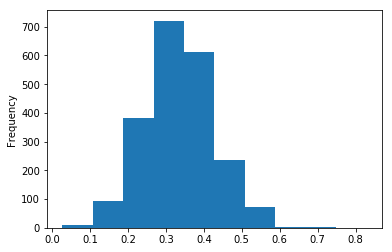

In [37]:
dist = []
for ct in tSeqs.values(): dist.append(ct['In']/float(ct['Total']))
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

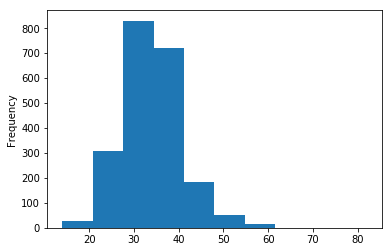

In [39]:
TcountsDist = Series(tCounts)
TcountsDist.plot.hist();

In [ ]:
TcountsDist[TcountsDist<20]

In [ ]:
for ind,count in TcountsDist[TcountsDist<20].items():
    seq = promoterSeqs[ind]
    counter = 0
    for i in range(0,len(seq)-8):
        counter+= int(seq[i:i+9] in knownTs)
    print (ind,count,counter)

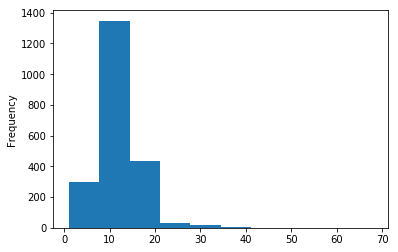

In [40]:
dist=[]
for rec in promoters.values():
    count = 0
    for i in range(0,len(rec.seq)-8):
        if str(rec.seq[i:i+9]) in knownTs: count += 1
    dist.append(count)    
dist = Series(dist)
dist.plot.hist();

#### Question 2b

In [41]:
def GenerateSeq(transMatrix,alpha,length):
    seq = str(randBase(alpha))
    for i in range(length-1):
        seq += randBase(transMatrix[seq[-1]])
    return seq

from numpy import prod
def T_s(seq,pwm,alphas,transMatrix,H_proms):
    tCount = 0
    for i in range(0,len(seq)-8):
        subseq = seq[i:i+9]
        alpha_ho = pwm[1][seq[i]]
        alpha_ha = alphas[seq[i]]
        HoList = [transMatrix[pos+1][subseq[pos]][subseq[pos+1]] for pos in range(0,8)]
        HaList = [H_proms[subseq[pos]][subseq[pos+1]] for pos in range(0,8)]
        HoList.append(alpha_ho)
        HaList.append(alpha_ha)
        L_H_q1 = prod(HoList)
        L_H_promoters = prod(HaList)
        tCount += int(L_H_q1/L_H_promoters >= 1)
    return tCount

0. 0.141
1. 0.138
2. 0.134
3. 0.144
4. 0.137
5. 0.137
6. 0.137
7. 0.143
8. 0.136
9. 0.137
10. 0.136
11. 0.135
12. 0.133
13. 0.137
14. 0.132
15. 0.134
16. 0.137
17. 0.137
18. 0.140
19. 0.131
20. 0.137
21. 0.138
22. 0.134
23. 0.139
24. 0.143
25. 0.132
26. 0.133
27. 0.136
28. 0.135
29. 0.137
30. 0.136
31. 0.141
32. 0.135
33. 0.135
34. 0.132
35. 0.133
36. 0.137
37. 0.137
38. 0.132
39. 0.136
40. 0.136
41. 0.136
42. 0.139
43. 0.140
44. 0.135
45. 0.136
46. 0.132
47. 0.136
48. 0.136
49. 0.140
count    50.000000
mean      0.136391
std       0.002959
min       0.131095
25%       0.134900
50%       0.136305
75%       0.137454
max       0.144375
dtype: float64


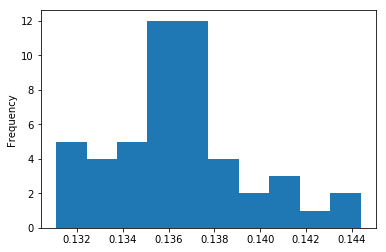

In [44]:
# I ran this part for kicks. I wanted to see what the LRT would look like if I concattenated all of the motifs together
combinedMotifs = "".join(seqs)
dist = []
for index in range(50):
    counter = 0
    total = 0
    for i in range(0,len(combinedMotifs)-8):
        subseq = combinedMotifs[i:i+9]
        L_H_q1 = pwm[1][combinedMotifs[i]]
        L_H_promoters = alphas[index][combinedMotifs[i]]
        for pos in range(0,8):
            L_H_q1 *= transMat[pos+1][subseq[pos]][subseq[pos+1]]
            L_H_promoters *= H_promoters[index][subseq[pos]][subseq[pos+1]]
        counter += int((L_H_promoters != 0) and (L_H_q1/L_H_promoters >= 1))
        total +=1
    dist.append(counter/float(total))
    print("%i. %.3f" %(index,counter/float(total)))
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

In [ ]:
#This part was run in a python script on the HPC for time reasons
numSims = 100
for index in range(len(H_promoters)):
    tSuccesses = 0
    for sim in range(numSims):
        genSeq = GenerateSeq(H_promoters[index],alphas[index],1000)
        tSuccesses += int(T_s(genSeq,pwm,alphas[index],transMat,H_promoters[index]) >= tCounts[index])
    print(index,tSuccesses/float(numSims))

In [46]:
df = read_csv("PvaluesOfMC_Q2.txt", names=["SeqID","Pval"],sep=" ")
print("Significant P-Values at the alpha = .15 cuttoff:",len(df[df.Pval <= .15]))

Significant P-Values at the alpha = .15 cuttoff: 535


<h2><a id="hw2qs">Homework 2 Questions</a></h2>

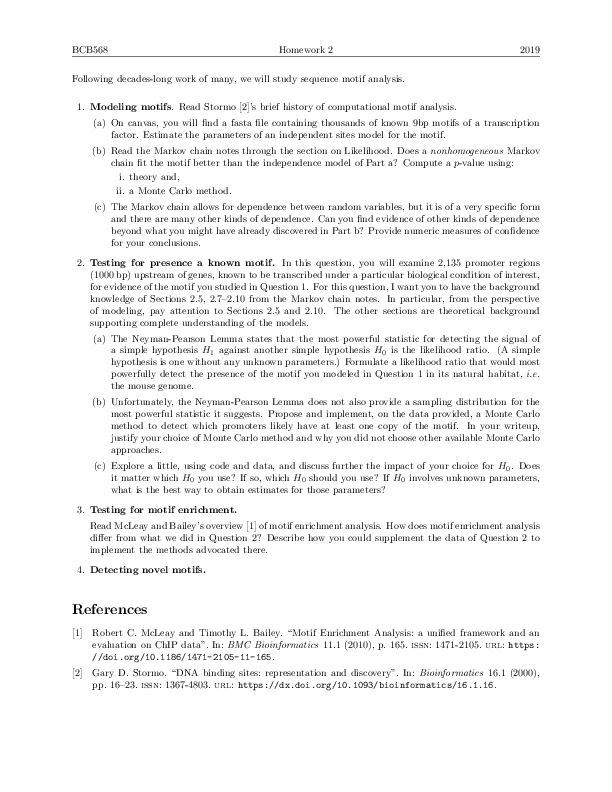

In [47]:
imageFromPdf = WImage(filename='HW2_AssignmentStatement.pdf')  
pages = len(imageFromPdf.sequence)  
image = WImage( width=imageFromPdf.width, height=imageFromPdf.height * pages)  
for i in range(pages):  image.composite(imageFromPdf.sequence[i], top=imageFromPdf.height * i, left=0)  
image.format="png"  
image 

<h4><a id="refs"><u>References</u></a></h4>

<h4><a id="stormo">1. Stromo Paper</a></h4>

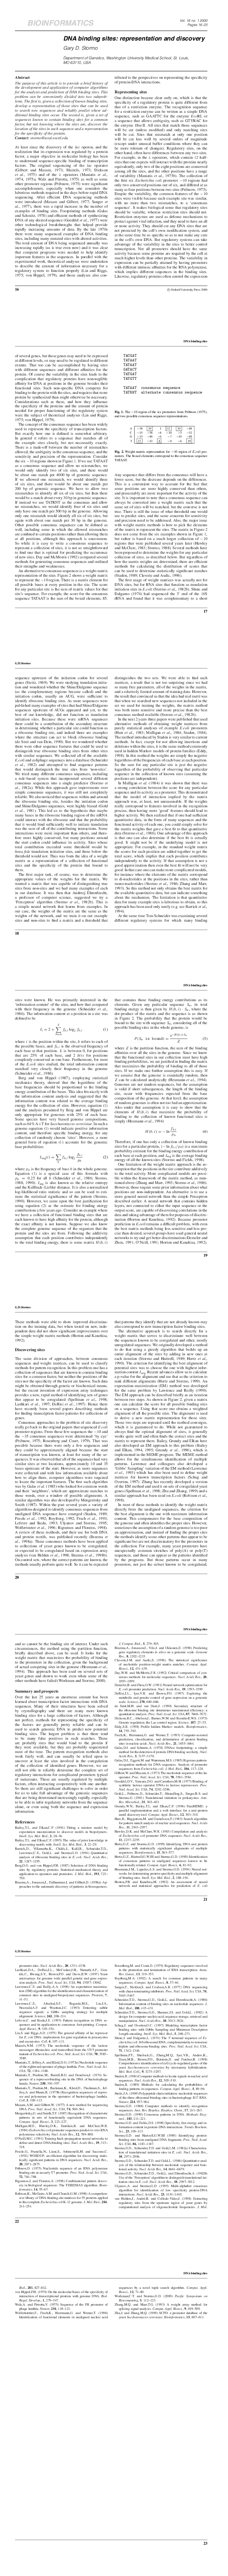

In [48]:
imageFromPdf = WImage(filename='Stormo_2000.pdf')  
pages = len(imageFromPdf.sequence)  
image = WImage( width=imageFromPdf.width, height=imageFromPdf.height * pages)  
for i in range(pages):  image.composite(imageFromPdf.sequence[i], top=imageFromPdf.height * i, left=0)  
image.format="png"  
image 

<h4><a id="mcmc">2. Markov Chain Notes</a></h4>

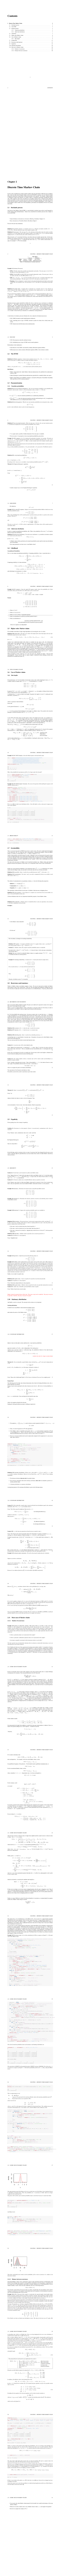

In [49]:
imageFromPdf = WImage(filename='mch.pdf')  
pages = len(imageFromPdf.sequence)  
image = WImage( width=imageFromPdf.width, height=imageFromPdf.height * pages)  
for i in range(pages):  image.composite(imageFromPdf.sequence[i], top=imageFromPdf.height * i, left=0)  
image.format="png"  
image 

In [ ]:
import threading
thread1 = threading.Thread(target=simulateMarkovChainModelOrderN, args=(list(pwm2.values()),transMat2,100000,2))
thread2 = threading.Thread(target=simulateMarkovChainModelOrderN, args=(list(pwm2.values()),transMat2,100000,2))
# Will execute both in parallel
s1=thread1.start()
s2=thread2.start()
# Joins threads back to the parent process, which is this
# program

val1 = thread1.join()
val2 = thread2.join()

import multiprocessing
global pval
p1 = multiprocessing.Process(target=simulateMarkovChainModelOrderN, args=(list(pwm2.values()),transMat2,100000,2))
p2 = multiprocessing.Process(target=simulateMarkovChainModelOrderN, args=(list(pwm2.values()),transMat2,100000,2))
p1.start()
p2.start()
p1.join()
p2.join()
    
    # Wont print because processes run using their own memory location                     
print("here",pval)

In [ ]:
# Do an order 3 mc instead of order 2
P3s = {}
#Initialize the Ps matrix
for pos in range(1,9):
    P3s[pos]={}
    for firstBase,secondBase,thirdBase,fourthBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        try: P3s[pos][firstBase+secondBase+thirdBase][fourthBase] = 0.0
        except: P3s[pos][firstBase+secondBase+thirdBase] = {fourthBase:0.0}

#Count the number of times each base is found together
for seq in seqs:
    for pos in range(0,6): P3s[pos+1][seq[pos:pos+3]][seq[pos+3]]+=1

#Compute the transition matrix        
transMat3 = {}
for pos in range(1,9):
    transMat3[pos] = {}
    for firstBase,secondBase,thirdBase,fourthBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        rc_total = Series(P3s[pos][firstBase+secondBase+thirdBase]).sum()
        if rc_total == 0.0:
            try:transMat3[pos][firstBase+secondBase+thirdBase][fourthBase] = 0.0
            except: transMat3[pos][firstBase+secondBase+thirdBase] = {fourthBase: 0.0}
            continue
        try: transMat3[pos][firstBase+secondBase+thirdBase][fourthBase] = P3s[pos][firstBase+secondBase+thirdBase][fourthBase]/rc_total
        except: transMat3[pos][firstBase+secondBase+thirdBase] = {fourthBase: P3s[pos][firstBase+secondBase+thirdBase][fourthBase]/rc_total}

#Compute the null (order 2 model)
LL_Ho = 0.0
for seq in seqs:
    LL_Ho += log(pwm2[seq[0:2]])
    for pos in range(0,7):
        LL_Ho += log(transMat2[pos+1][seq[pos:pos+2]][seq[pos+2]])
print("LL_Ho",LL_Ho)      

#Compute the alphas for order 3
pwm3 = {}
for pair in transMat3[1]:
    countSum = Series(P3s[1][pair]).sum()
    pwm3[pair] = countSum/len(seqs)
    
#Compute the alternate (order 3 model)
LL_Ha = 0.0
for seq in seqs:
    LL_Ha += log(pwm3[seq[0:3]])
    for pos in range(0,6):
        LL_Ha += log(transMat3[pos+1][seq[pos:pos+3]][seq[pos+3]])
print("LL_Ha",LL_Ha) 
lmbda = 2*(LL_Ha-LL_Ho)
print(lmbda)
df = (64*4*5+16*4 - (4*6)+16) -  (64*7+16 - (4*7)+4)
chi2.pdf(lmbda,df)

# Do an order 4 mc instead of order 3

P4s = {}
#Initialize the Ps matrix
for pos in range(1,9):
    P4s[pos]={}
    for firstBase,secondBase,thirdBase,fourthBase,fifthBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        try: P4s[pos][firstBase+secondBase+thirdBase+fourthBase][fifthBase] = 0
        except: P4s[pos][firstBase+secondBase+thirdBase+fourthBase] = {fifthBase:0}

#Count the number of times each base is found together
for seq in seqs:
    for pos in range(0,5): P4s[pos+1][seq[pos:pos+4]][seq[pos+4]]+=1

#Compute the transition matrix        
transMat4 = {}
for pos in range(1,9):
    transMat4[pos] = {}
    for firstBase,secondBase,thirdBase,fourthBase,fifthBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        rc_total = Series(P4s[pos][firstBase+secondBase+thirdBase+fourthBase]).sum()
        if rc_total == 0.0:
            try:transMat4[pos][firstBase+secondBase+thirdBase+fourthBase][fifthBase] = 0.0
            except: transMat4[pos][firstBase+secondBase+thirdBase+fourthBase] = {fifthBase: 0.0}
            continue
        try: transMat4[pos][firstBase+secondBase+thirdBase+fourthBase][fifthBase] = P4s[pos][firstBase+secondBase+thirdBase+fourthBase][fifthBase]/rc_total
        except: transMat4[pos][firstBase+secondBase+thirdBase+fourthBase] = {fifthBase: P4s[pos][firstBase+secondBase+thirdBase+fourthBase][fifthBase]/rc_total}

#Compute the null (order 2 model)
LL_Ho = 0.0
for seq in seqs:
    LL_Ho += log(pwm3[seq[0:3]])
    for pos in range(0,6):
        LL_Ho += log(transMat3[pos+1][seq[pos:pos+3]][seq[pos+3]])
print("LL_Ho",LL_Ho)      

#Compute the alphas for order 3
pwm4 = {}
for pair in transMat4[1]:
    countSum = Series(P4s[1][pair]).sum()
    pwm4[pair] = countSum/len(seqs)
    
#Compute the alternate (order 3 model)
LL_Ha = 0.0
for seq in seqs:
    LL_Ha += log(pwm4[seq[0:4]])
    for pos in range(0,5):
        LL_Ha += log(transMat4[pos+1][seq[pos:pos+4]][seq[pos+4]])
print("LL_Ha",LL_Ha) 
lmbda = 2*(LL_Ha-LL_Ho)
print(lmbda)
df = (64*4*4*4+16*4*4 - (4*5)+16) -  (64*7+16 - (4*7)+4)
chi2.pdf(lmbda,df)

# Do an order 5 mc instead of order 4

P5s = {}
#Initialize the Ps matrix
for pos in range(1,9):
    P5s[pos]={}
    for firstBase,secondBase,thirdBase,fourthBase,fifthBase,sixthBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        try: P5s[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase][sixthBase] = 0
        except: P5s[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase] = {sixthBase:0}

#Count the number of times each base is found together
for seq in seqs:
    for pos in range(0,4): P5s[pos+1][seq[pos:pos+5]][seq[pos+5]]+=1

#Compute the transition matrix        
transMat5 = {}
for pos in range(1,9):
    transMat5[pos] = {}
    for firstBase,secondBase,thirdBase,fourthBase,fifthBase,sixthBase in cartProduct(['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T'],['A','C','G','T']):
        rc_total = Series(P5s[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase]).sum()
        if rc_total == 0.0:
            try:transMat5[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase][sixthBase] = 0.0
            except: transMat5[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase] = {sixthBase: 0.0}
            continue
        try: transMat5[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase][sixthBase] = P5s[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase][sixthBase]/rc_total
        except: transMat5[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase] = {sixthBase: P5s[pos][firstBase+secondBase+thirdBase+fourthBase+fifthBase][sixthBase]/rc_total}

#Compute the null (order 4 model)
LL_Ho = 0.0
for seq in seqs:
    LL_Ho += log(pwm4[seq[0:4]])
    for pos in range(0,5):
        LL_Ho += log(transMat4[pos+1][seq[pos:pos+4]][seq[pos+4]])
print("LL_Ho",LL_Ho)      

#Compute the alphas for order 5
pwm5 = {}
for pair in transMat5[1]:
    countSum = Series(P5s[1][pair]).sum()
    pwm5[pair] = countSum/len(seqs)
    
#Compute the alternate (order 3 model)
LL_Ha = 0.0
for seq in seqs:
    LL_Ha += log(pwm5[seq[0:5]])
    for pos in range(0,4):
        LL_Ha += log(transMat5[pos+1][seq[pos:pos+5]][seq[pos+5]])
print("LL_Ha",LL_Ha) 
lmbda = 2*(LL_Ha-LL_Ho)
print(lmbda)
df = (64*4*4*4+16*4*4 - (4*5)+16) -  (64*7+16 - (4*7)+4)
chi2.pdf(lmbda,df)